# House Price Prediction - Comprehensive Data Science Project
### —— Data Science Project for Exploratory Data Analysis (EDA), Statistical Inference, Feature Engineering, and Machine Learning.

#### Dataset downloaded from Kaggle
[<span style='color:#1f77b4'>**House Prices - Advanced Regression Techniques**</span>](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

### Life cycle of the Project:
- Understand the Problem
- Exploratory Data Analysis (Part 1)
  - whole picture of the data
  - univariate analysis

- Exploratory Data Analysis (Part 2)
  - Variable Correlation/Dependency Analysis
  - inferential statistics with hypothesis testing

- Feature Engineering
- <span style='color:blue'>**Feature Importance Analysis**</span>
- Machine Learning Model Building, evaluation, and deployment

# Feature Importance Analysis Phase
**get a sense of which features are of the most importance in house price prediction**   
- use preprocessed data saved in Feature Engineering phase
- train regularized linear regression models (Lasso, Rige):  
  - use parameter tunning technique to choose the most suitable regularization parameter (alpha)
  - train the model with selected parameter
  - select and visualize features with largest absolute coefficients
  - model residual plots to check model fitting
  - feature selection stability analysis
  

<a name="0"></a>
# Content Outline
- [1. Packages, Datasets, and Customized Functions](#1)
  - [Packages](#1.1)
  - [Version Information](#1.2)
  - [Datasets](#1.3)
  - [Customized Functions](#1.4)
- [2. Model Training and Feature Importance Analysis](#2)
  - [2.1 r2-scored Lasso Regression Model](#2.1)
  - [2.2 RMSE-scored Lasso Regression Model](#2.2)
  - [2.3 Ridge Regression Model](#2.3)
- [3. Stability of Feature Selection](#3)


<a name="1"></a>
# 1. Packages, Datasets, and Customized Functions
- [Packages](#1.1)
- [Version Information](#1.2)
- [Datasets](#1.3)
- [Customized Functions](#1.4)

<a name="1.1"></a>
### Packages

In [1]:
###### import modules ####################################
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats # for QQ plot
from matplotlib.offsetbox import AnchoredText # for text annotation in plt plots
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error

import session_info
import warnings
import inspect
import json

sns.set_style('darkgrid')  ## set seaborn style
# warnings.filterwarnings('ignore') ## ignore warnings
pd.pandas.set_option('display.max_columns',None) ## Display all the columns of the dataframe

<a name="1.2"></a>
### version information for all imported modules
- use `session_info` to output version information for modules loaded in the current session, Python, the OS, and the CPU.
- version information is provided to increase reproducibility

In [2]:
session_info.show(std_lib=True, html=False)

-----
inspect             NA
io                  NA
json                2.0.9
matplotlib          3.6.2
numpy               1.23.4
pandas              1.5.1
scipy               1.9.3
seaborn             0.12.1
session_info        1.0.0
sklearn             1.1.3
warnings            NA
-----
IPython             8.6.0
jupyter_client      7.4.5
jupyter_core        5.0.0
jupyterlab          3.5.0
notebook            6.5.2
-----
Python 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]
Windows-10-10.0.22000-SP0
-----
Session information updated at 2022-11-14 11:41


<a name="1.3"></a>
### Datasets
**Import Preprocessed Datasets and Prepare Training Data**
- preprocessed datasets are created and saved as .csv files in **Feature Engineering** phase

In [3]:
###### import original datasets for reference if needed: train.csv, test.csv #######################
main_df = pd.read_csv('datasets/train.csv')
test_df = pd.read_csv('datasets/test.csv')

In [4]:
###### import preprocessed datasets: train_processed.csv, test_processed.csv ####################
main_processed = pd.read_csv('datasets_processed/train_processed.csv')
test_processed = pd.read_csv('datasets_processed/test_processed.csv')

In [5]:
main_pro = main_processed.copy()
test_pro = test_processed.copy()

In [6]:
###### prepare training + test data for model training: only use main_pro ############################
X_main_pro, y_main_pro = main_pro.drop('SalePrice', axis=1), np.log(main_pro[['SalePrice']])

In [7]:
###### train_test_split ######################
X_train, X_test, y_train, y_test = train_test_split(X_main_pro, y_main_pro, test_size = 0.2, random_state = 0)

<a name="1.4"></a>
### Customized Functions

In [8]:
### function that displays model information after training
def display_model_info(model, mdl_str, score_metric, X_test = X_test, y_test = y_test):
    """
    Display model information after training.
    
    Params:
    --------
    model (GridSearchCV model)   : fitted GridSearchCV regression model
    mdl_str (str)                : string representation of the model
    score_metric (str)           : string representation of scoring metric used by GridSearchCV
    X_test, y_test (pd.DataFrame): test data feature and target variable data frame
    
    Returns:
    --------
    text summary of fitted model:
      model name, scoring metric, best parameter, number of non-zero coefficients, 
      best score of grid search model on training data, score on test data
    
    """
    print('Model: {}'.format(mdl_str))
    print('Scoring Metric: {}'.format(score_metric))
    print('-' * 20)
    print('best parameter achieved by grid-search model:{}'.format(model.best_params_))
    print(('number of non-zero coefficients: {} out of {}'
           .format((model.best_estimator_.coef_ != 0).sum(), X_test.shape[1])))
    print('best {} score achieved by grid-search model:{}'.format(score_metric, model.best_score_))
    if score_metric == 'r2':
        print('r2 score on test set:{}'.format(r2_score(y_test, model.predict(X_test))))
    if score_metric == 'neg_mean_squared_error':
        print(('mean_squared_error score on test set:{}'
               .format(mean_squared_error(y_test, model.predict(X_test)))))
    if score_metric == 'neg_root_mean_squared_error':
        print(('root_mean_squared_error score on test set:{}'
               .format(mean_squared_error(y_test, model.predict(X_test), squared=False))))
    return

In [9]:
### function that gets features with largest absolute coefficients
def get_top_feat_coef(model, mdl_str, coef_num = 50, X_train = X_train, fontsize = 8, figsize = (6, 6)):
    """
    Return and plot features with largest absolute coefficients for a specific fitted model.
    
    Params:
    --------
    model (GridSearchCV model): fitted GridSearchCV regression model
    mdl_str (str)         : string representation of the model
    coef_num (str)        : number of features expected to return
    X_train (pd.DataFrame): training data feature data frame
    fontsize (int, float) : text font size in plot
    figsize (tuple)       : figure size of plot
    
    Returns:
    --------
    coef_top (pd.Series):
      index : feature names 
      values: coefficent values of corresponding features  
    plt figure of bar plot
    
    """
    coef = pd.Series(model.best_estimator_.coef_.reshape(-1), index = X_train.columns)
    coef_top = coef.sort_values(key = abs, ascending = False)[: coef_num].sort_values()
    plt.figure(figsize=figsize)
    coef_top.plot(kind = 'barh', fontsize = fontsize)
    ax = plt.gca()
    ax.set(xlabel='coefficients', 
           title=('top {} feature coefficients of {} model (alpha = {})'
                  .format(coef_num, mdl_str, model.best_params_['alpha'])))
    return coef_top

In [10]:
### function that creates multipule plots to check residuals
def plot_resid(model, mdl_str, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    """
    Create plot matrix to check model residuals.
    
    Params:
    --------
    model (GridSearchCV model)     : fitted GridSearchCV regression model
    mdl_str (str)                  : string representation of the model
    X_train, y_train (pd.DataFrame): training data feature and target variable data frame
    X_test, y_test (pd.DataFrame)  : test data feature and target variable data frame
    
    Returns:
    --------
    plt figure:
      subplots include scatter plot, histogram & kde plot, and QQ-plot
    
    """
    fig, axs = plt.subplots(3, 2, figsize = (9, 10))
    axs = axs.flatten()
    plt.sca(axs[0])
    plt.scatter(x = model.predict(X_train).reshape(-1), y = y_train, s = 25, alpha = 0.8, 
                edgecolors = 'white', label = 'training data')
    plt.scatter(x = model.predict(X_test).reshape(-1), y = y_test, s = 25, alpha = 0.8, 
                edgecolors = 'white', label = 'test data')
    sns.regplot(x = model.predict(X_train).reshape(-1), y = y_train, scatter = False, 
                color = 'red', line_kws = {'linewidth': 1.5}, ax = axs[0])
    axs[0].set(xlabel='predicted values', ylabel='true values', 
               title='predicted vs. true values')
    plt.legend()
    
    plt.sca(axs[1])
    plt.scatter(x = model.predict(X_train).reshape(-1), 
                y = y_train.iloc[:, 0] - model.predict(X_train).reshape(-1), 
                s = 25, alpha = 0.8, edgecolors = 'white', label = 'training data')
    plt.scatter(x = model.predict(X_test).reshape(-1), 
                y = y_test.iloc[:, 0] - model.predict(X_test).reshape(-1), 
                s = 25, alpha = 0.8, edgecolors = 'white', label = 'test data')
    axs[1].set(xlabel='predicted values', ylabel='residuals', 
               title='predicted values vs. residuals')
    plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = 'red')
    plt.legend()
    
    plt.sca(axs[2])
    sns.histplot(y_train.iloc[:, 0] - model.predict(X_train).reshape(-1), bins = 50, 
                 kde = True, ax = axs[2])
    axs[2].set(xlabel='log_SalePrice', title='histogram & kde plot of residuals for training data')
    
    plt.sca(axs[3])
    sns.histplot(y_test.iloc[:, 0] - model.predict(X_test).reshape(-1), bins = 50,
                 kde = True, color = '#ff7f0e', ax = axs[3])
    axs[3].set(xlabel='log_SalePrice', title='histogram & kde plot of residuals for test data')
    
    plt.sca(axs[4])
    values = y_train.iloc[:, 0] - model.predict(X_train).reshape(-1)
    stats.probplot(values, plot = axs[4])
    text=(('training data residuals:\nskew = {:.3f}\n$\\mu$ = {:.3f}\n$\\sigma$ = {:.3f}\n\n'
           .format(values.skew(), values.mean(), values.std()))) 
    anchored_text = AnchoredText(text, loc = 'upper left', prop=dict(size=10), frameon=False)
    axs[4].add_artist(anchored_text)
    
    plt.sca(axs[5])
    values = y_test.iloc[:, 0] - model.predict(X_test).reshape(-1)
    stats.probplot(values, plot = axs[5])
    text=(('test data residuals:\nskew = {:.3f}\n$\\mu$ = {:.3f}\n$\\sigma$ = {:.3f}\n\n'
           .format(values.skew(), values.mean(), values.std()))) 
    anchored_text = AnchoredText(text, loc = 'upper left', prop=dict(size=10), frameon=False)
    axs[5].add_artist(anchored_text)
    
    plt.suptitle('residual plot of {} model (alpha = {})'.format(mdl_str, model.best_params_['alpha']), 
                 fontsize = 13)
    plt.subplots_adjust(top=0.9)
    plt.tight_layout()
    
    return plt.show()

In [11]:
### function that returns selected top features for multiple samples of training data
def check_sample_feat_selection(num_sample, sample_size, num_feat, X_train = X_train, y_train = y_train):
    """
    Return selected top features for each of multiple sample sets of training data.
    
    Params:
    --------
    num_sample (int): number of sample sets (iterations) for model fitting and feature selection
    sample_size (int): size of each sample (out of whole training data)
    num_feat (int): number of features expected to select
    X_train, y_train (pd.DataFrame): training data feature and target variable data frame
    
    Returns:
    --------
    sel_feats_df (pd.DataFrame): 
      each column represents a feature set selected for the corresponding fitted model
    
    Notes:
    --------
    regression model is set as Lasso(alpha = 0.0002, random_state = 0)
    
    """
    sel_feats_dict = {}
    for i in range(num_sample):
        X_train_smpl = X_train.sample(n = sample_size, random_state = i)
        y_train_smpl = y_train.sample(n = sample_size, random_state = i)
        lasso = Lasso(alpha = 0.0002, random_state = 0).fit(X_train_smpl, y_train_smpl)
        coef = pd.Series(lasso.coef_.reshape(-1), index = X_train.columns)
        coef_top = (coef.sort_values(key = abs, ascending = False)[: num_feat]
                    .sort_values(ascending = False))
        sel_feats_dict['sample_{}'.format(i + 1)] = coef_top.index.tolist()
    
    sel_feats_df = pd.DataFrame(sel_feats_dict)
    
    return sel_feats_df

In [12]:
###### check function docstring ###################################
print(inspect.getdoc(plot_resid)) # or press shift + tab after typing in function name

Create plot matrix to check model residuals.

Params:
--------
model (GridSearchCV model)     : fitted GridSearchCV regression model
mdl_str (str)                  : string representation of the model
X_train, y_train (pd.DataFrame): training data feature and target variable data frame
X_test, y_test (pd.DataFrame)  : test data feature and target variable data frame

Returns:
--------
plt figure:
  subplots include scatter plot, histogram & kde plot, and QQ-plot


*back to [content outline](#0)*

<a name="2"></a>
# 2. Model Training and Feature Importance Analysis
- [2.1 r2-scored Lasso Regression Model](#2.1)
- [2.2 RMSE-scored Lasso Regression Model](#2.2)
- [2.3 Ridge Regression Model](#2.3)

<a name="2.1"></a>
## 2.1 r2-scored Lasso Regression Model  
**r2 scoring metric**
- [model training and parameter tunning](#2.1.1)
- [feature importance visualization](#2.1.2)
- [model residual plots](#2.1.3)

<a name="2.1.1"></a>
### model training and parameter tunning
- use `GridSearchCV` for parameter tunning

In [14]:
reg_lasso = Lasso(random_state = 0)
grid_values = {'alpha': [0.001, 0.003, 0.005, 0.008, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}
# [0.03, 0.05, 0.5, 1, 2, 3, 5, 10, 15, 20, 30]
grid_lasso_r2 = GridSearchCV(reg_lasso, param_grid = grid_values, cv = 5, scoring = 'r2', verbose = 1)
grid_lasso_r2.fit(X_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=5, estimator=Lasso(random_state=0),
             param_grid={'alpha': [0.001, 0.003, 0.005, 0.008, 0.01, 0.015,
                                   0.02, 0.025, 0.03, 0.035, 0.04, 0.045,
                                   0.05]},
             scoring='r2', verbose=1)

In [15]:
grid_lasso_r2.best_estimator_

Lasso(alpha=0.001, random_state=0)

In [16]:
display_model_info(model = grid_lasso_r2, mdl_str = 'Lasso', score_metric = 'r2')

Model: Lasso
Scoring Metric: r2
--------------------
best parameter achieved by grid-search model:{'alpha': 0.001}
number of non-zero coefficients: 73 out of 203
best r2 score achieved by grid-search model:0.9123915874066661
r2 score on test set:0.9308750588324013


#### fine tunning with alpha centered around 0.001

In [17]:
reg_lasso = Lasso(random_state = 0)
grid_values = {'alpha': [0.0001, 0.0002, 0.0005, 0.0008, 0.001, 0.0012, 0.0015]}
grid_lasso_r2_1 = GridSearchCV(reg_lasso, param_grid = grid_values, cv = 5, scoring = 'r2', verbose = 1)
grid_lasso_r2_1.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5, estimator=Lasso(random_state=0),
             param_grid={'alpha': [0.0001, 0.0002, 0.0005, 0.0008, 0.001,
                                   0.0012, 0.0015]},
             scoring='r2', verbose=1)

In [18]:
display_model_info(model = grid_lasso_r2_1, mdl_str = 'Lasso', score_metric = 'r2')

Model: Lasso
Scoring Metric: r2
--------------------
best parameter achieved by grid-search model:{'alpha': 0.0002}
number of non-zero coefficients: 137 out of 203
best r2 score achieved by grid-search model:0.9189711839827321
r2 score on test set:0.9343821166379509


<a name="2.1.2"></a>
### Feature Importance Analysis
**use fine-tuned model (alpha = 0.0002) for feature importance analysis**

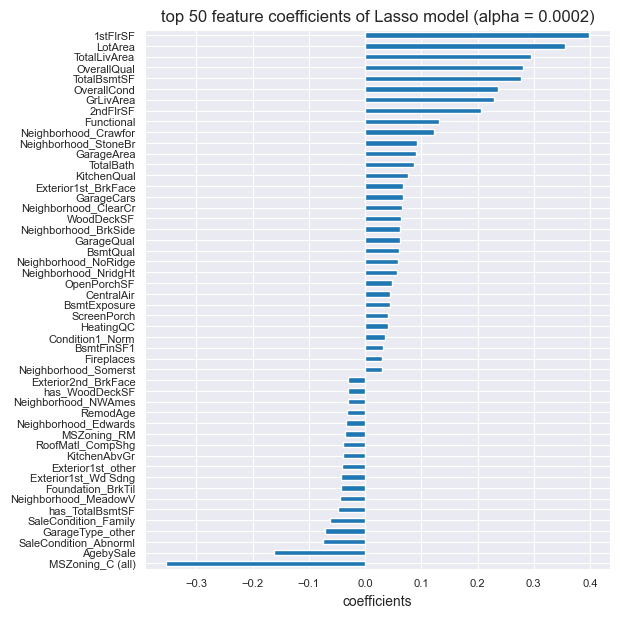

In [19]:
top_coefs = get_top_feat_coef(model = grid_lasso_r2_1, mdl_str = 'Lasso', coef_num = 50, figsize = (6, 7))

In [20]:
pd.DataFrame({'feature': top_coefs.sort_values(ascending = False).index.tolist(), 
              'coefficient': top_coefs.sort_values(ascending = False).values})

,feature,coefficient
0,1stFlrSF,0.398223
1,LotArea,0.355078
2,TotalLivArea,0.295841
3,OverallQual,0.280335
4,TotalBsmtSF,0.277419
5,OverallCond,0.236220
6,GrLivArea,0.228880
7,2ndFlrSF,0.205548
8,Functional,0.131336
9,Neighborhood_Crawfor,0.122442


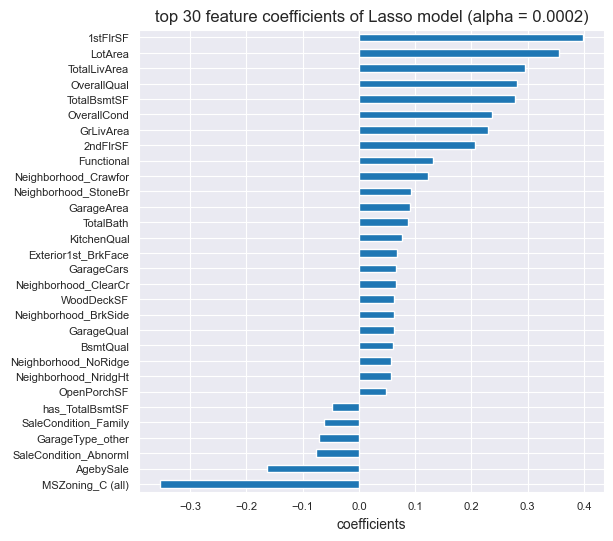

In [21]:
top_coefs = get_top_feat_coef(model = grid_lasso_r2_1, mdl_str = 'Lasso', coef_num = 30)

#### summary:
- From the visulization, it shows some continuous and ordinal features are among the top positive factors that affect house price. 
  - These features include `1stFlrSF`, `LotArea`, `TotalLivArea`, `OverallQual`, `TotalBsmtSF`, `OverallCond`, etc.
  - Intuitively these features capture the overall quality of a house and quantify some of the basic living areas people seem to care about most when considering purchasing a house
- Some categorical features also play key roles in house price prediction
  - These features include `Neighborhood`, `Salecondition`, `MSZoning`, etc.
  - Some neighborhoods affect positively on house price, some negtively. Intuitively this makes sence since house prices often change a lot from neighborhood to neighborhood in the city.
  - It seems 'MSZoning_C (all)' has strong negtive impact on house sale price. Specifically, `MSZoning` feature is an identification of 'the general zoning classification of the sale', and house sale records with 'C (all)' category is classified as Commercial. Basically this means that houses in commercial zone have much lower prices than other houses.
- `AgebySale`, a newly created feature based on original `YearBuilt` and `YrSold`, also has strong negtive impact on house price. This makes sence since older houses are often less expensive.


<a name="2.1.3"></a>
### model residual plots
**use fine-tuned model (alpha = 0.0002)**

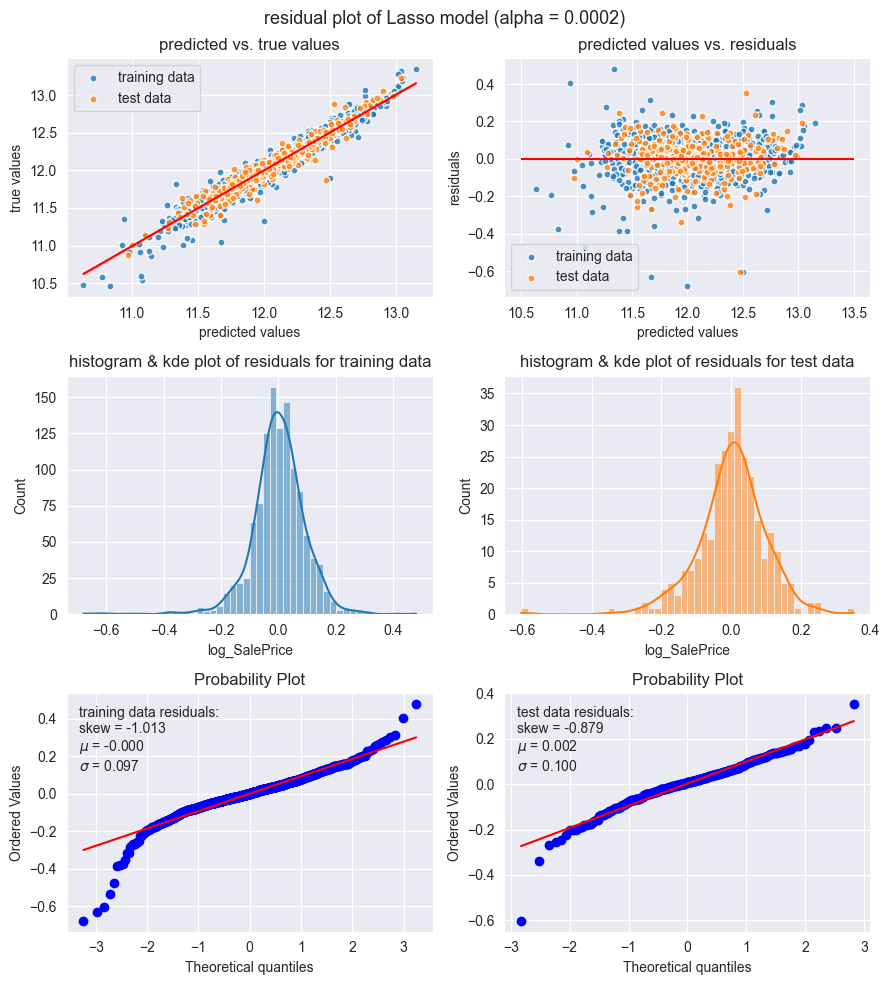

In [22]:
plot_resid(model = grid_lasso_r2_1, mdl_str = 'Lasso', 
           X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

#### summary:
- 2nd picture of residual plot shows that residuals seem to be randomly distributed and randomly  
  scattered around the centerline for both training and test data  
- the randomness and normality of residual distribution can be further confirmed with the histogram  
  and QQ-plot, which both show that the model is fitted properly
- this means the model is able to capture most of the explanatory information and the feature  
  importance analysis makes sence 
  
  
  *back to [2. Model Training and Feature Importance Analysis](#2)*

<a name="2.2"></a>
## 2.2 RMSE-scored Lasso Regression Model 
**root_mean_squared_error (RMSE) scoring metric**
- [model training and parameter tunning](#2.2.1)
- [feature importance visualization](#2.2.2)
- [model residual plots](#2.2.3)

<a name="2.2.1"></a>
### model training and parameter tunning

In [23]:
reg_lasso = Lasso(random_state = 0)
grid_values = {'alpha': [0.001, 0.003, 0.005, 0.008, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}
grid_lasso_rmse = GridSearchCV(reg_lasso, param_grid = grid_values, cv = 5, 
                               scoring = 'neg_root_mean_squared_error', verbose = 1)
grid_lasso_rmse.fit(X_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=5, estimator=Lasso(random_state=0),
             param_grid={'alpha': [0.001, 0.003, 0.005, 0.008, 0.01, 0.015,
                                   0.02, 0.025, 0.03, 0.035, 0.04, 0.045,
                                   0.05]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [24]:
display_model_info(model = grid_lasso_rmse, mdl_str = 'Lasso', score_metric = 'neg_root_mean_squared_error')

Model: Lasso
Scoring Metric: neg_root_mean_squared_error
--------------------
best parameter achieved by grid-search model:{'alpha': 0.001}
number of non-zero coefficients: 73 out of 203
best neg_root_mean_squared_error score achieved by grid-search model:-0.11623764351118622
root_mean_squared_error score on test set:0.10221619847865665


#### fine tunning with alpha centered around 0.001

In [25]:
reg_lasso = Lasso(random_state = 0)
grid_values = {'alpha': [0.0001, 0.0002, 0.0005, 0.0008, 0.001, 0.0012, 0.0015]}
grid_lasso_rmse_1 = GridSearchCV(reg_lasso, param_grid = grid_values, cv = 5, 
                                 scoring = 'neg_root_mean_squared_error', verbose = 1)
grid_lasso_rmse_1.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5, estimator=Lasso(random_state=0),
             param_grid={'alpha': [0.0001, 0.0002, 0.0005, 0.0008, 0.001,
                                   0.0012, 0.0015]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [26]:
display_model_info(model = grid_lasso_rmse_1, mdl_str = 'Lasso', score_metric = 'neg_root_mean_squared_error')

Model: Lasso
Scoring Metric: neg_root_mean_squared_error
--------------------
best parameter achieved by grid-search model:{'alpha': 0.0002}
number of non-zero coefficients: 137 out of 203
best neg_root_mean_squared_error score achieved by grid-search model:-0.11179621471195164
root_mean_squared_error score on test set:0.09958947578379908


<a name="2.2.2"></a>
### Feature Importance Analysis
**use fine-tuned model (alpha = 0.0002) for feature importance analysis**

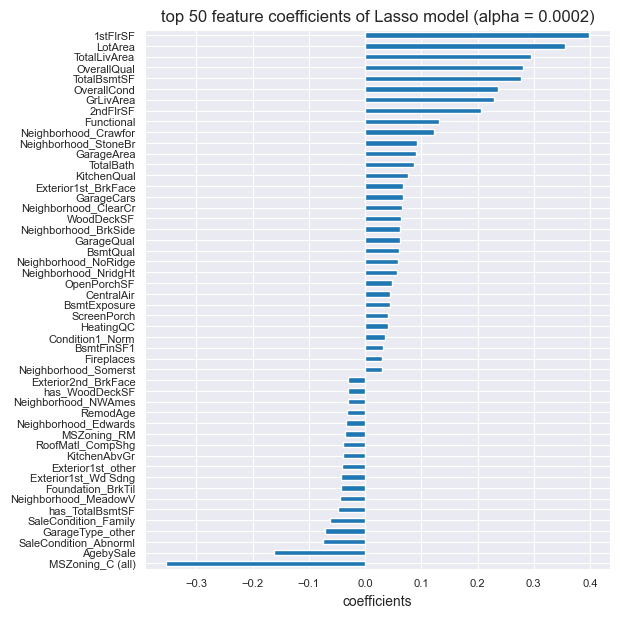

In [27]:
top_coefs = get_top_feat_coef(model = grid_lasso_rmse_1, mdl_str = 'Lasso', coef_num = 50, figsize = (6, 7))

In [28]:
pd.DataFrame({'feature': top_coefs.sort_values(ascending = False).index.tolist(), 
              'coefficient': top_coefs.sort_values(ascending = False).values})

,feature,coefficient
0,1stFlrSF,0.398223
1,LotArea,0.355078
2,TotalLivArea,0.295841
3,OverallQual,0.280335
4,TotalBsmtSF,0.277419
5,OverallCond,0.236220
6,GrLivArea,0.228880
7,2ndFlrSF,0.205548
8,Functional,0.131336
9,Neighborhood_Crawfor,0.122442


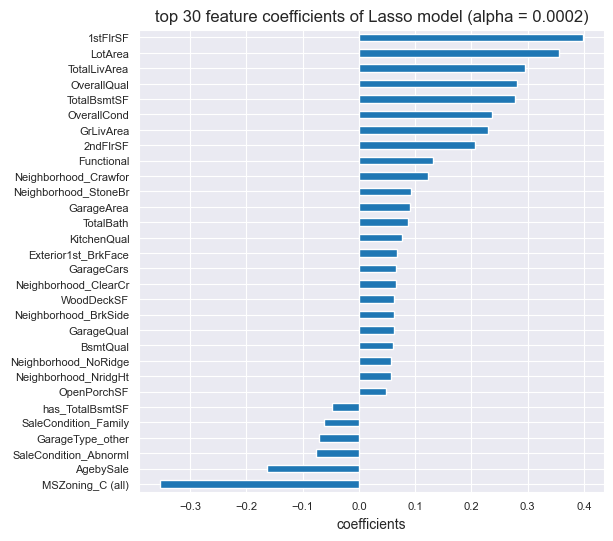

In [29]:
top_coefs = get_top_feat_coef(model = grid_lasso_rmse_1, mdl_str = 'Lasso', coef_num = 30)

<a name="2.2.3"></a>
### model residual plots
**use fine-tuned model (alpha = 0.0002)**

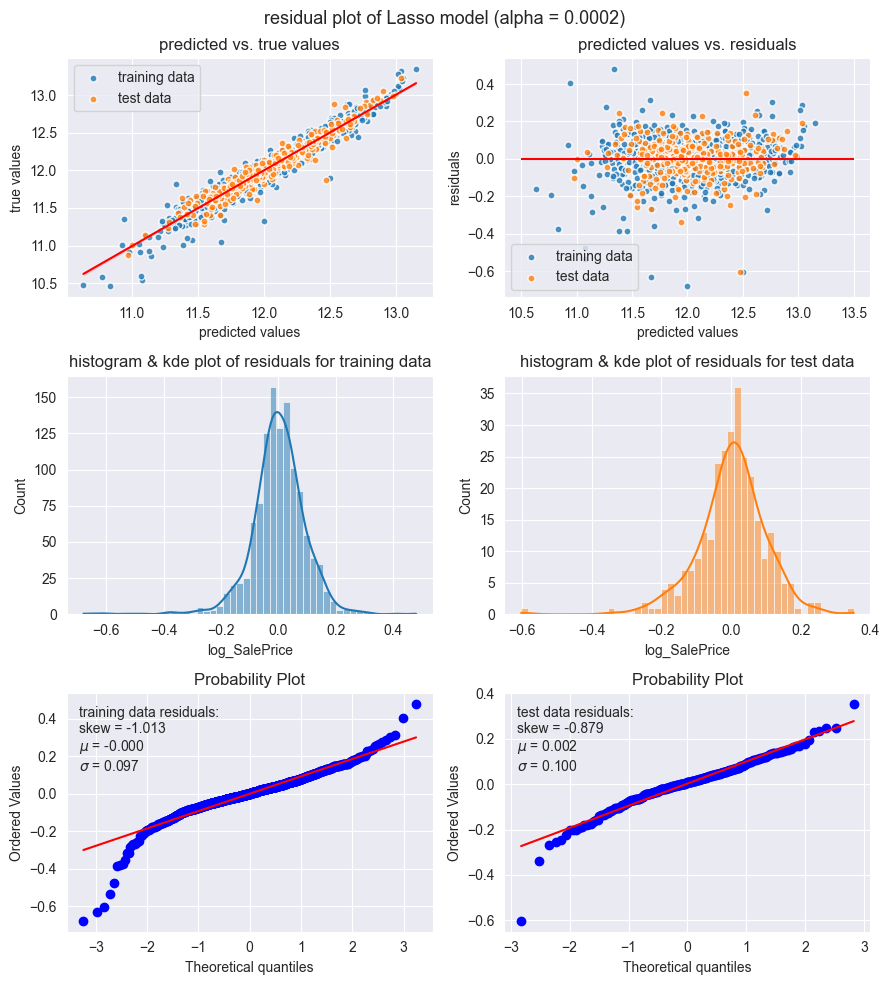

In [30]:
plot_resid(model = grid_lasso_rmse_1, mdl_str = 'Lasso', 
           X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

#### observation and summary:
- feature importance analysis for r2 and rmse scoring metrics get the same best parameter and coefficients, as well as top features


 *back to [2. Model Training and Feature Importance Analysis](#2)*

<a name="2.3"></a>
## 2.3 Ridge Regression Model
**root_mean_squared_error (RMSE) scoring metric**
- [model training and parameter tunning](#2.3.1)
- [feature importance visualization](#2.3.2)
- [model residual plots](#2.3.3)

<a name="2.3.1"></a>
### model training and parameter tunning

In [31]:
reg_ridge = Ridge(random_state = 0)
grid_values = {'alpha': [0.03, 0.05, 0.5, 1, 2, 3, 5, 10, 15, 20, 30]}
grid_ridge_rmse = GridSearchCV(reg_ridge, param_grid = grid_values, cv = 5, 
                               scoring = 'neg_root_mean_squared_error', verbose = 1)
grid_ridge_rmse.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=5, estimator=Ridge(random_state=0),
             param_grid={'alpha': [0.03, 0.05, 0.5, 1, 2, 3, 5, 10, 15, 20,
                                   30]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [32]:
display_model_info(model = grid_ridge_rmse, mdl_str = 'Ridge', score_metric = 'neg_root_mean_squared_error')

Model: Ridge
Scoring Metric: neg_root_mean_squared_error
--------------------
best parameter achieved by grid-search model:{'alpha': 2}
number of non-zero coefficients: 203 out of 203
best neg_root_mean_squared_error score achieved by grid-search model:-0.11333051848547482
root_mean_squared_error score on test set:0.10127284182805292


#### fine tunning with alpha centered around 2

In [33]:
reg_ridge = Ridge(random_state = 0)
grid_values = {'alpha': [1.2, 1.3, 1.5, 1.6, 1.8, 1.9, 2, 2.1, 2.2, 2.5, 2.8, 3]}
grid_ridge_rmse_1 = GridSearchCV(reg_ridge, param_grid = grid_values, cv = 5, 
                               scoring = 'neg_root_mean_squared_error', verbose = 1)
grid_ridge_rmse_1.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=Ridge(random_state=0),
             param_grid={'alpha': [1.2, 1.3, 1.5, 1.6, 1.8, 1.9, 2, 2.1, 2.2,
                                   2.5, 2.8, 3]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [34]:
display_model_info(model = grid_ridge_rmse_1, mdl_str = 'Ridge', score_metric = 'neg_root_mean_squared_error')

Model: Ridge
Scoring Metric: neg_root_mean_squared_error
--------------------
best parameter achieved by grid-search model:{'alpha': 1.5}
number of non-zero coefficients: 203 out of 203
best neg_root_mean_squared_error score achieved by grid-search model:-0.11325718044043162
root_mean_squared_error score on test set:0.10121994014795055


#### observation and summary:
- unlike Lasso models, Ridge models keep all feature coefficients non-zero, but with smaller coefficients assigned to most 'important' features

<a name="2.3.2"></a>
### Feature Importance Analysis
**use fine-tuned model (alpha = 1.5) for feature importance analysis**

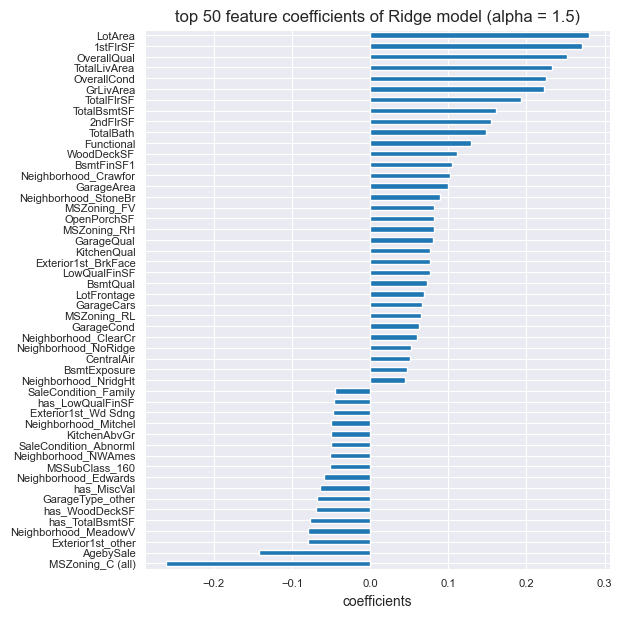

In [35]:
top_coefs = get_top_feat_coef(model = grid_ridge_rmse_1, mdl_str = 'Ridge', coef_num = 50, figsize = (6, 7))

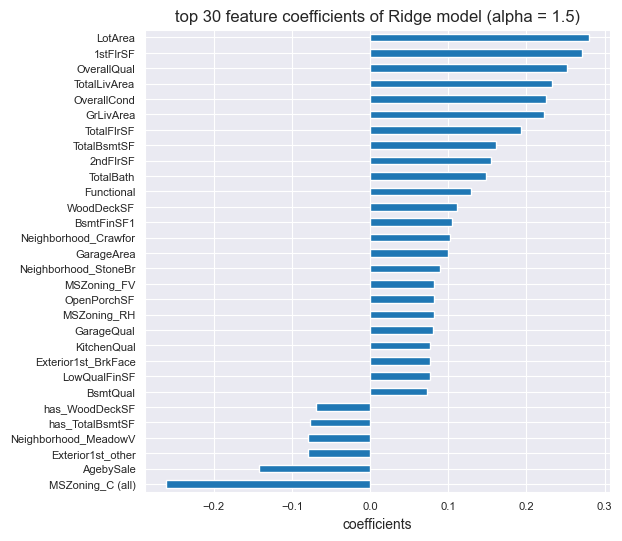

In [36]:
top_coefs = get_top_feat_coef(model = grid_ridge_rmse_1, mdl_str = 'Ridge', coef_num = 30)

In [37]:
pd.DataFrame({'feature': top_coefs.sort_values(ascending = False).index.tolist(), 
              'coefficient': top_coefs.sort_values(ascending = False).values})

,feature,coefficient
0,LotArea,0.280042
1,1stFlrSF,0.271299
2,OverallQual,0.251772
3,TotalLivArea,0.232397
4,OverallCond,0.225486
5,GrLivArea,0.222123
6,TotalFlrSF,0.193669
7,TotalBsmtSF,0.160577
8,2ndFlrSF,0.154903
9,TotalBath,0.148039


<a name="2.3.3"></a>
### model residual plots
**use fine-tuned model (alpha = 1.5)**

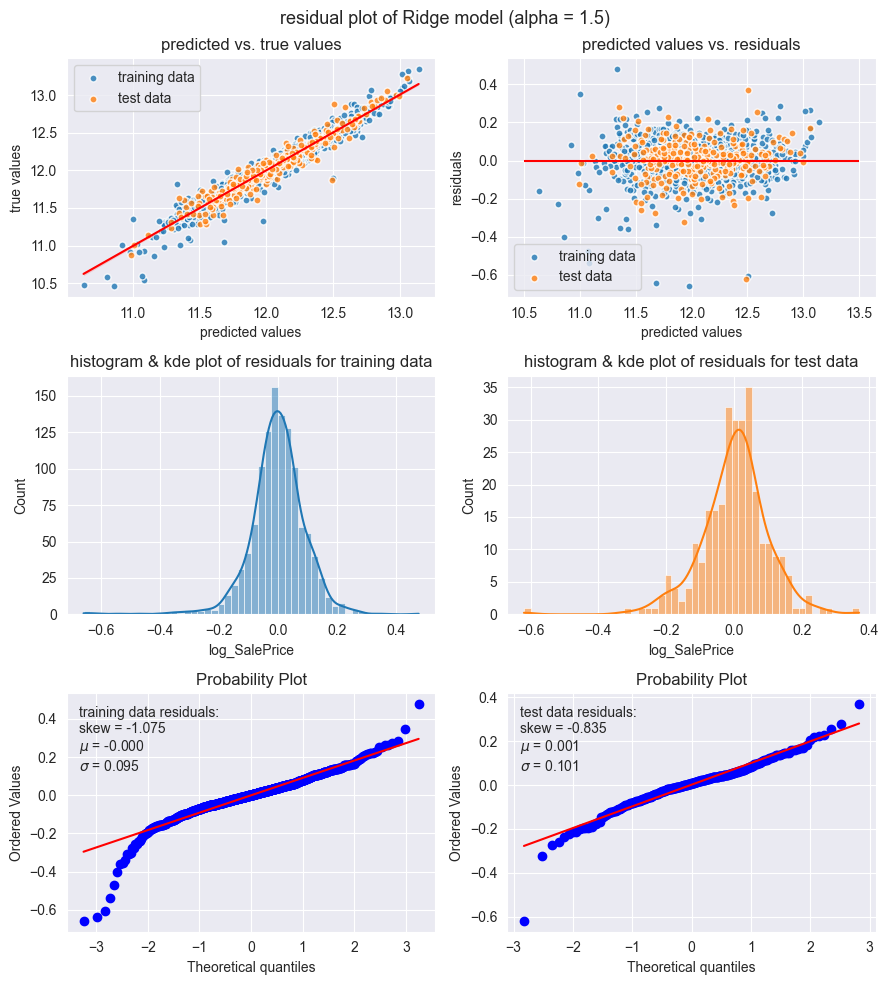

In [38]:
plot_resid(model = grid_ridge_rmse_1, mdl_str = 'Ridge', 
           X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

#### summary:
- similar to residual plot results from lasso regression models, the ridge model is also able to capture most of the explanatory information, which indicates that the feature importance analysis makes sence 
  
  
  *back to [2. Model Training and Feature Importance Analysis](#2)*   
  *back to [content outline](#0)*

<a name="3"></a>
# 3. Stability of Feature Selection
#### Question:
- what if we fit the same model multiple times with different subsets of training data each time? Will the selected top feature set be the same for each training process?

#### Method:     
**fit Lasso model with multiple bootstrapped samples of `X_train`**
- set alpha = 0.0002 for lasso model
- get same number of features with largest absolute coefficients for each sample data set
- compare selected features of each sample
- check how stable the feature selection process is

In [39]:
check_sample_feat_selection(num_sample = 10, sample_size = 800, num_feat = 30)

,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10
0,1stFlrSF,TotalLivArea,GrLivArea,LotArea,1stFlrSF,LotArea,LotArea,1stFlrSF,1stFlrSF,GrLivArea
1,TotalLivArea,GrLivArea,TotalBsmtSF,1stFlrSF,LotArea,1stFlrSF,TotalLivArea,TotalLivArea,LotArea,1stFlrSF
2,LotArea,LotArea,LotArea,TotalBsmtSF,GrLivArea,TotalLivArea,TotalBsmtSF,OverallQual,OverallQual,LotArea
3,OverallQual,OverallQual,OverallQual,OverallCond,TotalBsmtSF,OverallQual,GrLivArea,LotArea,2ndFlrSF,OverallCond
4,2ndFlrSF,1stFlrSF,OverallCond,OverallQual,OverallQual,OverallCond,1stFlrSF,OverallCond,TotalBsmtSF,TotalBsmtSF
5,TotalBsmtSF,OverallCond,1stFlrSF,GrLivArea,OverallCond,GrLivArea,OverallQual,TotalBsmtSF,OverallCond,OverallQual
6,OverallCond,TotalBsmtSF,Neighborhood_Crawfor,TotalLivArea,2ndFlrSF,2ndFlrSF,OverallCond,2ndFlrSF,TotalLivArea,TotalLivArea
7,Functional,WoodDeckSF,Functional,2ndFlrSF,Functional,TotalBsmtSF,2ndFlrSF,TotalBath,Functional,GarageArea
8,GarageArea,Functional,GarageArea,Functional,Neighborhood_Crawfor,GarageType_No Garage,Functional,GarageArea,GrLivArea,2ndFlrSF
9,Neighborhood_Crawfor,Neighborhood_Crawfor,TotalBath,GarageQual,BsmtFinSF1,Neighborhood_Crawfor,Neighborhood_Crawfor,Neighborhood_Crawfor,GarageArea,Functional


In [40]:
check_sample_feat_selection(num_sample = 10, sample_size = 800, num_feat = 10)

,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10
0,1stFlrSF,TotalLivArea,GrLivArea,LotArea,1stFlrSF,LotArea,LotArea,1stFlrSF,1stFlrSF,GrLivArea
1,TotalLivArea,GrLivArea,TotalBsmtSF,1stFlrSF,LotArea,1stFlrSF,TotalLivArea,TotalLivArea,LotArea,1stFlrSF
2,LotArea,LotArea,LotArea,TotalBsmtSF,GrLivArea,TotalLivArea,TotalBsmtSF,OverallQual,OverallQual,LotArea
3,OverallQual,OverallQual,OverallQual,OverallCond,TotalBsmtSF,OverallQual,GrLivArea,LotArea,2ndFlrSF,OverallCond
4,2ndFlrSF,1stFlrSF,OverallCond,OverallQual,OverallQual,OverallCond,1stFlrSF,OverallCond,TotalBsmtSF,TotalBsmtSF
5,TotalBsmtSF,OverallCond,1stFlrSF,GrLivArea,OverallCond,GrLivArea,OverallQual,TotalBsmtSF,OverallCond,OverallQual
6,OverallCond,TotalBsmtSF,Neighborhood_Crawfor,TotalLivArea,2ndFlrSF,2ndFlrSF,OverallCond,2ndFlrSF,TotalLivArea,TotalLivArea
7,Functional,WoodDeckSF,GarageType_other,2ndFlrSF,Functional,TotalBsmtSF,2ndFlrSF,TotalBath,Functional,GarageArea
8,AgebySale,AgebySale,AgebySale,Functional,AgebySale,AgebySale,AgebySale,Exterior1st_other,AgebySale,AgebySale
9,MSZoning_C (all),MSZoning_C (all),MSZoning_C (all),MSZoning_C (all),MSZoning_C (all),MSZoning_C (all),MSZoning_C (all),MSZoning_C (all),MSZoning_C (all),MSZoning_C (all)


#### summary:
- feature selection might not be stable: the features selected with each bootstrapped sample of `X_train` are slightly different from each other, in terms of both feature importance ranking and selected feature set
- this is mainly because of the colinearity among features
- overall the feature selection process with Lasso model can still roughly show which features are most important for house sale price prediction

*back to [content outline](#0)*